In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from readfile import readfile
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

In [2]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [3]:
fileDir = "/home/qiz103/PA4"
#torch.manual_seed(50)

In [4]:
def generateTrainList(filePath,oneHotDict):
    songList = []
    f = open(filePath)
    for line in f:
        if line == "<start>\n":
            song = []
            song.append(oneHotDict["~~"])
        elif line == "<end>\n":
            song.append(oneHotDict["~~~"])
            songList.append(song)
        else: 
            for char in line:
                song.append(oneHotDict[char])
                
    return songList
            
def chunkListHelper(song):
    chunkList = []
    for idx in range(math.floor(len(song) / 100)):
        chunk = song[(idx*100):((idx + 1)*100)]
        if len(chunk)!= 0:
            chunkList.append(chunk)
    chunk = song[(math.floor(len(song) / 100)*100):len(song)]
    if len(chunk)!= 0:
        chunkList.append(chunk)
    
    resultList = []
    for chunk in chunkList:
        result = np.empty([len(chunk),1,96])
        for seqIdx,seq in enumerate(chunk):
            result[seqIdx][0] = seq
        
        resultList.append(result)
            
            
    return resultList

In [5]:
filePath = fileDir + "/train.txt"
valPath = fileDir + "/val.txt"
testPath = fileDir + "/test.txt"
fileReader = readfile()
oneHotDict = fileReader.returnTheDict(filePath)
print(len(oneHotDict))
songList = generateTrainList(filePath,oneHotDict)
print(type(songList[0][0]))
print(len(songList[0][0]))
print("what is the type of note", songList[0][0].dtype)
valList = generateTrainList(valPath,oneHotDict)
testList = generateTrainList(testPath,oneHotDict)
random.shuffle(songList)

96
<class 'numpy.ndarray'>
96
what is the type of note float32


In [6]:
class DatasetCustom(data.Dataset):
    def __init__(self,songList):
        self.songList = songList
    def __len__(self):
        return len(self.songList)
    def __getitem__(self,index):
        return self.songList[index]
        

In [7]:
# testing part of Dataset generator 
datasetCustom = DatasetCustom(songList)
trainloader = torch.utils.data.DataLoader(datasetCustom, batch_size=1,
                                          shuffle=True)

In [8]:
class LSTMcustomize(nn.Module):
    def __init__(self,inputSize,hiddenSize,layerNum,dropout):
        super(LSTMcustomize,self).__init__()
        self.lstm = nn.LSTM(input_size = inputSize,hidden_size = hiddenSize,num_layers = layerNum,dropout = dropout)
        self.to_output = nn.Linear(hiddenSize,inputSize)
        #self.to_act = nn.Softmax()
        self.h0 = torch.zeros(layerNum,1,hiddenSize)
        self.c0 = torch.zeros(layerNum,1,hiddenSize)
        self.hiddenSize = hiddenSize
        self.inputSize = inputSize
        self.layerNum = layerNum
        
        
    def forward(self,input):
        self.h0 = self.h0.requires_grad_().to(computing_device)
        self.c0 = self.c0.requires_grad_().to(computing_device)
        #print("input is cuda",input.is_cuda)
        #print("is ho  cuda",self.h0.is_cuda)
        #print("is c0 cuda", self.c0.is_cuda)
        self.h0 = self.h0.float()
        self.c0 = self.c0.float()
        input = input.float()
        #print("type check", input.dtype)
        #print("type of h0 is ",self.h0.dtype)
        #print("type of c0 is ",self.c0.dtype)
        #self.h0.double()
        #self.c0.double()
        #input.double()
        output,(hn,cn) = self.lstm(input,(self.h0.detach(),self.c0.detach()))
        self.h0 = hn
        self.c0 = cn
        linearOut = self.to_output(output.view(-1,self.hiddenSize))
        #result = self.to_act(linearOut)
        return linearOut
    
    def setHiddenCell(self,h0,c0):
        self.h0 = h0
        self.c0 = c0
        
        
        
    
        
        

In [9]:
layerNum = 2
hiddenSize = 125
#lstm = LSTMcustomize(inputSize = 95 ,hiddenSize = 100,layerNum = 1,dropout = 0)
lstm = LSTMcustomize(inputSize = 96 ,hiddenSize = hiddenSize,layerNum = layerNum,dropout = 0).to(computing_device)
print(lstm)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(lstm.parameters(),lr = 0.01,momentum=0.9)

LSTMcustomize(
  (lstm): LSTM(96, 125, num_layers=2)
  (to_output): Linear(in_features=125, out_features=96, bias=True)
)


In [10]:

trainingLoss = []
validationLoss = []
testLoss = []
earlyStopPatience = 5
prevLoss = 5
counter = 0
for epoch in range(600):
    print("epoch is ",epoch)
    trainSumEachEpoch = 0
    trainchunkSum = 0
    valSumEachEpoch = 0
    valchunkSum = 0
    for trainSong in trainloader:
        chunkList = chunkListHelper(trainSong)
        for chunk in chunkList:
            #print("batch idx",trainchunkSum)
            #print("chunk is",chunk.shape)
            #print("train song is ",len(trainSong))
            target = np.empty([chunk.shape[0],chunk.shape[1],chunk.shape[2]])
            target[0:(chunk.shape[0]-1),0,:] = chunk[1:chunk.shape[0],0,:]
            target[(chunk.shape[0]-1):0,:] = oneHotDict["!!!!"]
            target = np.squeeze(target, axis=1)
            target = np.argmax(target,axis = 1)
            #print("target is", target)
            chunkTensor = torch.from_numpy(chunk)
            chunkTensor = chunkTensor.to(computing_device)
            targetTensor = torch.from_numpy(target)
            targetTensor = targetTensor.to(computing_device)
            lstm.zero_grad()
            predict = lstm(chunkTensor)
            #print("target tensor is",targetTensor)
            #print("target shape is ",targetTensor.shape)
            #print("output shape is ",predict.shape)
            targetTensor = targetTensor.type(torch.LongTensor)
            targetTensor = targetTensor.to(computing_device)
            loss = loss_function(predict,targetTensor)
            #print("batch is %s loss is %s",(trainchunkSum,loss))
            trainSumEachEpoch += loss
            trainchunkSum += 1
            loss.backward()
            optimizer.step()
        
        lstm.setHiddenCell(h0 = torch.zeros(layerNum,1,hiddenSize),c0 = torch.zeros(layerNum,1,hiddenSize))
        
    
    #save model
    trainSumEachEpoch = trainSumEachEpoch / trainchunkSum
    trainingLoss.append(trainSumEachEpoch.item())
    savePath ="./"+"%depoch%smodel.pt"%(epoch,"best")
    torch.save(lstm, fileDir+"/"+savePath)
    print("training error is",trainSumEachEpoch.item())
    print("model saved")
    

    with torch.no_grad():
        for valSong in valList:
            chunkList = chunkListHelper(valSong)
            for chunk in chunkList:
                target = np.empty([chunk.shape[0],chunk.shape[1],chunk.shape[2]])
                target[0:(chunk.shape[0]-1),0,:] = chunk[1:chunk.shape[0],0,:]
                target[(chunk.shape[0]-1):0,:] = oneHotDict["!!!!"]
                target = np.squeeze(target, axis=1)
                target = np.argmax(target,axis = 1)
                chunkTensor = torch.from_numpy(chunk)
                targetTensor = torch.from_numpy(target)
                targetTensor = targetTensor.long()
                chunkTensor = chunkTensor.to(computing_device)
                targetTensor = targetTensor.to(computing_device)
                predict = lstm(chunkTensor)
                loss = loss_function(predict,targetTensor)
                valSumEachEpoch+=loss
                valchunkSum+=1

        valSumEachEpoch = valSumEachEpoch / valchunkSum
        validationLoss.append(valSumEachEpoch.item())
        print("validation error is", valSumEachEpoch.item())
        
        # implement early stop
        if valSumEachEpoch.item() >= prevLoss:
            counter += 1
        else:
            counter = 0

        if counter > earlyStopPatience:
            print("stop training for exceeding patience ")
            break
        #print("epoch is )
        prevLoss = valSumEachEpoch.item()
        #print("trainging in epoch end")
        
        
            
            
        

epoch is  0


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTMcustomize. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


training error is 3.551583766937256
model saved
validation error is 3.377631902694702
epoch is  1
training error is 3.277944564819336
model saved
validation error is 3.155869483947754
epoch is  2
training error is 2.9442384243011475
model saved
validation error is 2.780625343322754
epoch is  3
training error is 2.5682921409606934
model saved
validation error is 2.5574920177459717
epoch is  4
training error is 2.3218631744384766
model saved
validation error is 2.3947696685791016
epoch is  5
training error is 2.112835645675659
model saved
validation error is 2.3148748874664307
epoch is  6
training error is 1.9621493816375732
model saved
validation error is 2.1903316974639893
epoch is  7
training error is 1.8545682430267334
model saved
validation error is 2.1487293243408203
epoch is  8
training error is 1.7716273069381714
model saved
validation error is 2.102526903152466
epoch is  9
training error is 1.7150893211364746
model saved
validation error is 2.0844383239746094
epoch is  10
traini

KeyboardInterrupt: 

In [11]:
#report metrics
modelPath = "14epochbestmodel.pt"
lstm = torch.load(modelPath)
valchunkSum = 0
valSumEachEpoch = 0
with torch.no_grad():
    for valSong in valList:
        chunkList = chunkListHelper(valSong)
        for chunk in chunkList:
            target = np.empty([chunk.shape[0],chunk.shape[1],chunk.shape[2]])
            target[0:(chunk.shape[0]-1),0,:] = chunk[1:chunk.shape[0],0,:]
            target[(chunk.shape[0]-1):0,:] = oneHotDict["!!!!"]
            target = np.squeeze(target, axis=1)
            target = np.argmax(target,axis = 1)
            chunkTensor = torch.from_numpy(chunk)
            targetTensor = torch.from_numpy(target)
            targetTensor = targetTensor.long()
            chunkTensor = chunkTensor.to(computing_device)
            targetTensor = targetTensor.to(computing_device)
            predict = lstm(chunkTensor)
            loss = loss_function(predict,targetTensor)
            valSumEachEpoch+=loss
            valchunkSum+=1

    valSumEachEpoch = valSumEachEpoch / valchunkSum
    print("validation loss is ",valSumEachEpoch.item())

testchunkSum = 0
testSumEachEpoch = 0
with torch.no_grad():
    for testSong in testList:
        chunkList = chunkListHelper(testSong)
        for chunk in chunkList:
            target = np.empty([chunk.shape[0],chunk.shape[1],chunk.shape[2]])
            target[0:(chunk.shape[0]-1),0,:] = chunk[1:chunk.shape[0],0,:]
            target[(chunk.shape[0]-1):0,:] = oneHotDict["!!!!"]
            target = np.squeeze(target, axis=1)
            target = np.argmax(target,axis = 1)
            chunkTensor = torch.from_numpy(chunk)
            targetTensor = torch.from_numpy(target)
            targetTensor = targetTensor.long()
            chunkTensor = chunkTensor.to(computing_device)
            targetTensor = targetTensor.to(computing_device)
            predict = lstm(chunkTensor)
            loss = loss_function(predict,targetTensor)
            testSumEachEpoch+=loss
            testchunkSum+=1

    testSumEachEpoch = testSumEachEpoch / testchunkSum
    print("test loss is ",testSumEachEpoch.item())

validation loss is  1.9348828792572021
test loss is  1.9618412256240845


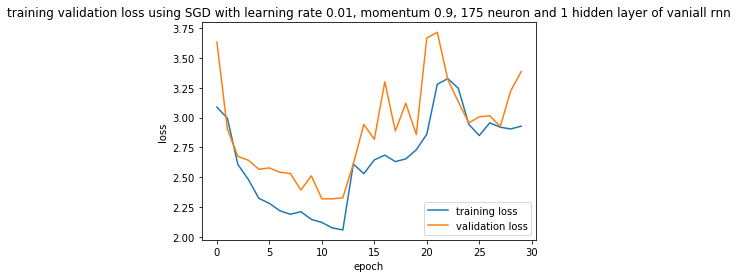

<Figure size 432x288 with 0 Axes>

In [18]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training validation loss using SGD with learning rate 0.01, momentum 0.9, 175 neuron and 1 hidden layer of vaniall rnn')
xAxis = np.arange(0,30)
plt.plot(xAxis,trainingLoss[0:30],label = 'training loss')
plt.plot(xAxis,validationLoss[0:30], label = 'validation loss')
plt.legend()
plt.show()
plt.savefig(fileDir + "test1.jpg")

In [ ]:
weights = torch.tensor([0.25, 0.25, 0.25, 0.25], dtype=torch.float) # create a tensor of weights
a = torch.multinomial(weights, 1)
a = a.numpy()

print(a)

In [15]:
musicName = "/experimentMusic.txt"
if os.path.exists(fileDir+musicName):
    os.remove(fileDir+musicName)
f = open(fileDir+musicName,"w")
modelPath = "15epochbestmodel.pt"
primeLength = 1
songIndex = 255
musicString = ""
temperature = 0.5
length = 1000

prime = songList[songIndex][0:primeLength]
for idx in range(primeLength):
    char = fileReader.noteList[np.argmax(songList[songIndex][idx])]
    if char == "~~":
        char = "<start>\n"
    
    if char == "~~~":
        char = "<end>\n"
        
    musicString += char
lstm = torch.load(modelPath)
with torch.no_grad():
    inputChunk = np.empty([len(prime),1,96])
    for seqIdx,seq in enumerate(prime):
        inputChunk[seqIdx][0] = seq
    inputChunk = torch.from_numpy(inputChunk)
    inputTensor = inputChunk.to(computing_device)
    predict = lstm(inputTensor)
    softmax = nn.Softmax(dim = 1)
    predict = softmax(predict / temperature)
    prevOutput = predict.cpu().detach().numpy()
    temp = predict[predict.shape[0]-1]
    prevOutputIndex = torch.multinomial(temp, 1)
    prevOutputIndex = prevOutputIndex.cpu().numpy()
    prevOutputIndex = prevOutputIndex[0]
    prevOutput = fileReader.noteList[prevOutputIndex]
    # comment out line 39 through 43 if want to prime with different music piece that is not <start>
    nextInput = np.empty([1,1,96])
    prevOutput = "~~"
    nextInput[0][0] = oneHotDict[prevOutput]
    nextInput = torch.from_numpy(nextInput)
    nextInput = nextInput.to(computing_device)
    
    for eachidx in range(length):
        prevOutput = lstm(nextInput)
        prevOutput = softmax(prevOutput / temperature)
        prevOutputIndex = torch.multinomial(prevOutput[0], 1)
        prevOutputIndex = prevOutputIndex.cpu().numpy()
        prevOutputIndex = prevOutputIndex[0]
        prevOutput = prevOutput.cpu().detach().numpy()
        prevOutput = fileReader.noteList[prevOutputIndex]
        if prevOutput != "!!!!":
            if prevOutput == "~~":
                musicString +=""
            elif prevOutput == "~~~":
                musicString +=""
            elif prevOutput == "\n":
                musicString +=""
            else:
                musicString += prevOutput
        
        nextInput = np.empty([1,1,96])
        nextInput[0][0] = oneHotDict[prevOutput]
        nextInput = torch.from_numpy(nextInput)
        nextInput = nextInput.to(computing_device)
        
        
        print("char is ",prevOutput)
                

musicString += "\n"
musicString += "<end>\n"
f.write(musicString)
f.close()

char is  X
char is  :
char is  5
char is  

char is  T
char is  :
char is  L
char is  e
char is   
char is  D
char is  o
char is  n
char is  n
char is  o
char is  r
char is  g
char is  i
char is  n
char is  e
char is  

char is  '
char is  :
char is  T
char is  r
char is  a
char is  n
char is  s
char is  c
char is  r
char is  i
char is  t
char is   
char is  e
char is  a
char is  r
char is   
char is  M
char is  i
char is  c
char is  h
char is  e
char is  l
char is   
char is  B
char is  e
char is  r
char is  l
char is  o
char is  n
char is   
char is  2
char is  0
char is  0
char is  6
char is  -
char is  2
char is  

char is  M
char is  :
char is  2
char is  |
char is  

char is  ~~
char is  :
char is  1
char is  /
char is  8
char is  

char is  ~~
char is  :
char is  1
char is  /
char is  4
char is  =
char is  1
char is  2
char is  

char is  ~~
char is  :
char is  

char is  d
char is   
char is  |
char is   
char is  e
char is  2
char is  e
char is  2
char is   
char is  |
char is

char is  2
char is  )
char is  B
char is  2
char is   
char is  |
char is   
char is  c
char is  2
char is  c
char is  2
char is   
char is  |
char is   
char is  F
char is  2
char is  G
char is  2
char is   
char is  |
char is   
char is  G
char is  2
char is   
char is  G
char is  2
char is   
char is  |
char is   
char is  c
char is  2
char is  c
char is  2
char is   
char is  |
char is   
char is  c
char is  4
char is   
char is  |
char is   
char is  B
char is  2
char is  c
char is  2
char is   
char is  |
char is   
char is  e
char is  2
char is  f
char is  2
char is   
char is  |
char is   
char is  e
char is  2
char is  d
char is  2
char is   
char is  |
char is   
char is  B
char is  2
char is  B
char is  2
char is   
char is  |
char is   
char is  B
char is  2
char is  G
char is  2
char is   
char is  |
char is   
char is  B
char is  2
char is   
char is  c
char is  2
char is   
char is  |
char is   
char is  c
char is  2
char is  c
char is  2
char is   
char is  |
char is   

In [14]:
musicName = "/compareMusic.txt"
if os.path.exists(fileDir+musicName):
    os.remove(fileDir+musicName)
f = open(fileDir+musicName,"w")
modelPath = "15epochbestmodel.pt"
primeLength = 1
songIndex = 255
musicString = ""
temperature = 0.5
length = 1000

prime = songList[songIndex][0:primeLength]
for idx in range(primeLength):
    char = fileReader.noteList[np.argmax(songList[songIndex][idx])]
    if char == "~~":
        char = "<start>\n"
    
    if char == "~~~":
        char = "<end>\n"
        
    musicString += char
lstm = torch.load(modelPath)
with torch.no_grad():

    nextInput = np.empty([1,1,96])
    prevOutput = "~~"
    nextInput[0][0] = oneHotDict[prevOutput]
    nextInput = torch.from_numpy(nextInput)
    nextInput = nextInput.to(computing_device)
    
    for eachidx in range(length):
        prevOutput = lstm(nextInput)
        prevOutput = prevOutput.cpu().detach().numpy()
        prevOutput = fileReader.noteList[np.argmax(prevOutput[0])]
        if prevOutput != "!!!!":
            if prevOutput == "~~":
                musicString +=""
            elif prevOutput == "~~~":
                musicString +=""
            elif prevOutput == "\n":
                musicString +=""
            else:
                musicString += prevOutput
        
        nextInput = np.empty([1,1,96])
        nextInput[0][0] = oneHotDict[prevOutput]
        nextInput = torch.from_numpy(nextInput)
        nextInput = nextInput.to(computing_device)
        
        
        print("char is ",prevOutput)
                

musicString += "\n"
musicString += "<end>\n"
f.write(musicString)
f.close()

char is  X
char is  :
char is  1
char is  

char is  T
char is  :
char is  L
char is  e
char is  i
char is   
char is  a
char is  l
char is  s
char is  o
char is   
char is  p
char is  a
char is  r
char is  l
char is  a
char is  n
char is  d
char is  e
char is  

char is  '
char is  :
char is  T
char is  r
char is  a
char is  n
char is  s
char is  c
char is  r
char is  i
char is  t
char is   
char is  e
char is  t
char is  /
char is  o
char is  u
char is   
char is  c
char is  o
char is  r
char is  r
char is  i
char is  g
char is  ?
char is   
char is  p
char is  a
char is  r
char is   
char is  M
char is  i
char is  c
char is  h
char is  e
char is  l
char is   
char is  B
char is  E
char is  L
char is  L
char is  O
char is  N
char is   
char is  -
char is   
char is  2
char is  0
char is  0
char is  5
char is  -
char is  0
char is  3
char is  -
char is  0
char is  6
char is  

char is  Z
char is  :
char is  P
char is  o
char is  u
char is  r
char is   
char is  t
char is  o
char is  u

char is  2
char is   
char is  B
char is  2
char is   
char is  |
char is   
char is  B
char is  2
char is   
char is  B
char is  2
char is   
char is  B
char is  2
char is   
char is  |
char is   
char is  B
char is  2
char is   
char is  B
char is  2
char is   
char is  B
char is  2
char is   
char is  |
char is   
char is  B
char is  2
char is   
char is  B
char is  2
char is   
char is  B
char is  2
char is   
char is  |
char is   
char is  B
char is  2
char is   
char is  B
char is  2
char is   
char is  B
char is  2
char is   
char is  |
char is   
char is  B
char is  2
char is   
char is  B
char is  2
char is   
char is  B
char is  2
char is   
char is  |
char is   
char is  B
char is  2
char is   


In [15]:
class vaRNN(nn.Module):
    def __init__(self,inputSize,hiddenSize,layerNum,dropout,nonlinearity):
        super(vaRNN,self).__init__()
        self.varnn = nn.RNN(input_size = inputSize,hidden_size = hiddenSize,num_layers = layerNum, nonlinearity = nonlinearity, dropout = dropout)
        self.to_output = nn.Linear(hiddenSize,inputSize)
        #self.to_act = nn.Softmax()
        self.h0 = torch.zeros(layerNum,1,hiddenSize)
        self.hiddenSize = hiddenSize
        self.inputSize = inputSize
        self.layerNum = layerNum
        
        
    def forward(self,input):
        self.h0 = self.h0.requires_grad_().to(computing_device)
        #print("input is cuda",input.is_cuda)
        #print("is ho  cuda",self.h0.is_cuda)
        #print("is c0 cuda", self.c0.is_cuda)
        self.h0 = self.h0.float()
        input = input.float()
        #print("type check", input.dtype)
        #print("type of h0 is ",self.h0.dtype)
        #print("type of c0 is ",self.c0.dtype)
        #self.h0.double()
        #self.c0.double()
        #input.double()
        output,hn = self.varnn(input,self.h0.detach())
        self.h0 = hn
        linearOut = self.to_output(output.view(-1,self.hiddenSize))
        #result = self.to_act(linearOut)
        return linearOut
    
    def setHiddenCell(self,h0):
        self.h0 = h0

In [16]:
layerNum = 1
hiddenSize = 175
#lstm = LSTMcustomize(inputSize = 95 ,hiddenSize = 100,layerNum = 1,dropout = 0)
rnn = vaRNN(inputSize = 96 ,hiddenSize = hiddenSize,layerNum = layerNum,nonlinearity = 'tanh',dropout = 0).to(computing_device)
print(rnn)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(),lr = 0.01,momentum=0.9)

vaRNN(
  (varnn): RNN(96, 175)
  (to_output): Linear(in_features=175, out_features=96, bias=True)
)


In [17]:
trainingLoss = []
validationLoss = []
testLoss = []
earlyStopPatience = 5
prevLoss = 5
counter = 0
for epoch in range(600):
    print("epoch is ",epoch)
    trainSumEachEpoch = 0
    trainchunkSum = 0
    valSumEachEpoch = 0
    valchunkSum = 0
    for trainSong in trainloader:
        chunkList = chunkListHelper(trainSong)
        for chunk in chunkList:
            #print("batch idx",trainchunkSum)
            #print("chunk is",chunk.shape)
            #print("train song is ",len(trainSong))
            target = np.empty([chunk.shape[0],chunk.shape[1],chunk.shape[2]])
            target[0:(chunk.shape[0]-1),0,:] = chunk[1:chunk.shape[0],0,:]
            target[(chunk.shape[0]-1):0,:] = oneHotDict["!!!!"]
            target = np.squeeze(target, axis=1)
            target = np.argmax(target,axis = 1)
            #print("target is", target)
            chunkTensor = torch.from_numpy(chunk)
            chunkTensor = chunkTensor.to(computing_device)
            targetTensor = torch.from_numpy(target)
            targetTensor = targetTensor.to(computing_device)
            rnn.zero_grad()
            predict = rnn(chunkTensor)
            #print("target tensor is",targetTensor)
            #print("target shape is ",targetTensor.shape)
            #print("output shape is ",predict.shape)
            targetTensor = targetTensor.type(torch.LongTensor)
            targetTensor = targetTensor.to(computing_device)
            loss = loss_function(predict,targetTensor)
            #print("batch is %s loss is %s",(trainchunkSum,loss))
            trainSumEachEpoch += loss
            trainchunkSum += 1
            loss.backward()
            optimizer.step()
        
        rnn.setHiddenCell(h0 = torch.zeros(layerNum,1,hiddenSize))
        
    
    #save model
    trainSumEachEpoch = trainSumEachEpoch / trainchunkSum
    trainingLoss.append(trainSumEachEpoch.item())
    savePath ="./"+"%depoch%smodelRNN.pt"%(epoch,"test")
    torch.save(rnn, fileDir+"/"+savePath)
    print("training error is",trainSumEachEpoch.item())
    print("model saved")
    

    with torch.no_grad():
        for valSong in valList:
            chunkList = chunkListHelper(valSong)
            for chunk in chunkList:
                target = np.empty([chunk.shape[0],chunk.shape[1],chunk.shape[2]])
                target[0:(chunk.shape[0]-1),0,:] = chunk[1:chunk.shape[0],0,:]
                target[(chunk.shape[0]-1):0,:] = oneHotDict["!!!!"]
                target = np.squeeze(target, axis=1)
                target = np.argmax(target,axis = 1)
                chunkTensor = torch.from_numpy(chunk)
                targetTensor = torch.from_numpy(target)
                targetTensor = targetTensor.long()
                chunkTensor = chunkTensor.to(computing_device)
                targetTensor = targetTensor.to(computing_device)
                predict = rnn(chunkTensor)
                loss = loss_function(predict,targetTensor)
                valSumEachEpoch+=loss
                valchunkSum+=1

        valSumEachEpoch = valSumEachEpoch / valchunkSum
        validationLoss.append(valSumEachEpoch.item())
        print("validation error is", valSumEachEpoch.item())
        
        # implement early stop
        if valSumEachEpoch.item() >= prevLoss:
            counter += 1
        else:
            counter = 0

        if counter > earlyStopPatience:
            print("stop training for exceeding patience ")
            break
        #print("epoch is )
        prevLoss = valSumEachEpoch.item()
        #print("trainging in epoch end")

epoch is  0


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type vaRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


training error is 3.0872368812561035
model saved
validation error is 3.6311991214752197
epoch is  1
training error is 2.9938716888427734
model saved
validation error is 2.903294563293457
epoch is  2
training error is 2.6069746017456055
model saved
validation error is 2.6757330894470215
epoch is  3
training error is 2.4810240268707275
model saved
validation error is 2.6426453590393066
epoch is  4
training error is 2.323190927505493
model saved
validation error is 2.566760301589966
epoch is  5
training error is 2.281740665435791
model saved
validation error is 2.578308343887329
epoch is  6
training error is 2.219601631164551
model saved
validation error is 2.5425515174865723
epoch is  7
training error is 2.1909146308898926
model saved
validation error is 2.5319619178771973
epoch is  8
training error is 2.211850166320801
model saved
validation error is 2.393230676651001
epoch is  9
training error is 2.1477394104003906
model saved
validation error is 2.511629343032837
epoch is  10
training

KeyboardInterrupt: 

In [ ]:
musicName = "/experimentMusic.txt"
modelPath = "15epochbestmodel.pt"
fileReader = open(fileDir+musicName)
characterList = []
hiddenState = []
for line in fileReader:
    for char in line:
        characterList.append(char)
        
Lstm = torch.load(modelPath)
softmax = nn.Softmax()
with torch.no_grad():
    for eachChar in characterList:
        input = oneHotDict[eachChar]
        input = torch.from_numpy(input)
        inputTensor = torch.empty(1,1,96)
        inputTensor[0][0] = input
        inputTensor = inputTensor.to(computing_device)
        out = Lstm(inputTensor)
        newweightlist = []
        weight = list(Lstm.lstm.parameters())
        for eachweight in weight:
            temp = eachweight.data
            newweightlist.append(softmax(temp))
        hiddenState.append(newweightlist)
        

In [ ]:


harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


In [ ]:
def heatmap(data,ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
data = np.random.randn(6, 6)
y = ["Prod. {}".format(i) for i in range(10, 70, 10)]
x = ["Cycle {}".format(i) for i in range(1, 7)]

qrates = np.array(list("ABCDEFG"))
norm = matplotlib.colors.BoundaryNorm(np.linspace(-3.5, 3.5, 8), 7)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: qrates[::-1][norm(x)])

im, _ = heatmap(data, y, x, ax=ax3,
                cmap=plt.get_cmap("PiYG", 7), norm=norm,
                cbar_kw=dict(ticks=np.arange(-3, 4), format=fmt),
                cbarlabel="Quality Rating")

annotate_heatmap(im, valfmt=fmt, size=9, fontweight="bold", threshold=-1,
                 textcolors=["red", "black"])